In [1]:
%matplotlib inline

In [2]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import celerite
from celerite import terms
import emcee

In [3]:
### TESS data import ###
data = np.loadtxt("tessbpic.dat",usecols=(0,1))
time = data[:,0][0:1414]
#time = np.reshape(time,[32,int(62976/32)])
flux = data[:,1][0:1414]
#flux = np.reshape(flux,[32,int(62976/32)])

mean = np.mean(flux)
flux-=mean

norm = np.max(flux)
flux/=norm

day1 = time[0]
time-=day1
flux_error = 1e-6*np.ones_like(time)
# time = np.sort(np.append(
#     np.random.uniform(0, 3.8, 5700),
#     np.random.uniform(5.5, 10, 6800),
# ))  # The input coordinates must be sorted
# flux_error = np.random.uniform(0.08, 0.22, len(time))
# flux = np.sin(3*time + 0.1*(time-5)**2) + flux_error * np.random.randn(len(time))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


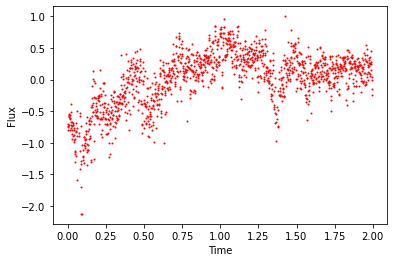

In [4]:
### Data plot ###
fig = plt.figure()
ax = plt.gca()
ax.scatter(time,flux,c="r",s=1)
ax.set_xlabel("Time")
ax.set_ylabel("Flux")
fig.show()

In [5]:
### GP Model ###
Q = 10.
w0 = 10.
S0 = 10.
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0))

gp = celerite.GP(kernel,fit_mean=True)
gp.compute(time,yerr=flux_error)

print("Initial log likelihood: {0}".format(gp.log_likelihood(flux)))
print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))

Initial log likelihood: -450252.28405972384
parameter_dict:
OrderedDict([('kernel:log_S0', 2.302585092994046), ('kernel:log_Q', 2.302585092994046), ('kernel:log_omega0', 2.302585092994046), ('mean:value', 0.0)])



In [6]:
x = np.linspace(np.min(time),np.max(time),10000)
pred_mean, pred_var = gp.predict(flux, x, return_var=True)
pred_std = np.sqrt(pred_var)

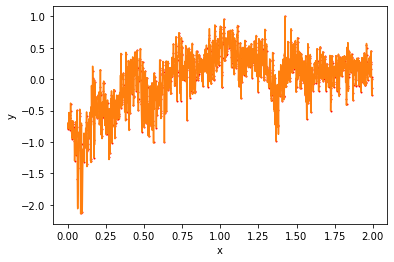

In [7]:
color = "#ff7f0e"
plt.scatter(time,flux,c="r",s=1)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [8]:
### Minimize ###
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)
# extract our initial guess at parameters
# from the celerite kernel and put it in a 
# vector:
p0 = gp.get_parameter_vector()


# run optimization:
results = minimize(neg_log_like, p0, method='L-BFGS-B',args=(flux, gp))
print(results)
print("Final log-likelihood: {0}".format(-results.fun))
print(np.exp(results.x))
print("Parameters: {0}".format(gp.get_parameter_dict()))
gp.set_parameter_vector(results.x)

      fun: 935.4056379435485
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7.86587293e+01,  1.18458956e+01, -3.32381160e+02, -2.08046913e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 110
      nit: 16
   status: 0
  success: True
        x: array([2.31192986e+00, 1.49885346e+00, 3.88994037e+00, 3.38120833e-04])
Final log-likelihood: -935.4056379435485
[10.09388564  4.4765536  48.90797007  1.00033818]
Parameters: OrderedDict([('kernel:log_S0', 2.311929857961032), ('kernel:log_Q', 1.498853464341847), ('kernel:log_omega0', 3.8899403703383526), ('mean:value', 0.0003381308331571567)])


In [9]:
### Prédiction avec les nouveaux paramètres calculés ###
pred_mean, pred_var = gp.predict(flux, x, return_var=True)
pred_std = np.sqrt(pred_var)

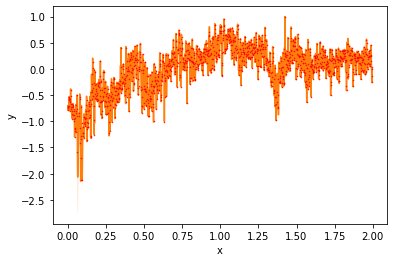

In [10]:
### Plot du posterior du minimize ###
color = "#ff7f0e"
plt.errorbar(time,flux,yerr=0,fmt=".r",capsize=0,markersize=1)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3, edgecolor="none",interpolate=True)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [11]:
### Définition de la likelihood ###
def log_likelihood(params,time,flux):
    gp.set_parameter_vector(params)
    ll = gp.log_likelihood(flux)
    return ll if np.isfinite(ll) else np.inf

In [12]:
### Définition du prior (uniforme) ###
def log_prior(params):
    if ((0 < params[0] < 10) and (0 < params[1] < 10) and (0 < params[2] < 10) and (-10 < params[3] < 10)) :
        return 0
    return -np.inf

In [13]:
### Définition du posterior ###
def log_probability(params,time,flux):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params,time,flux) if np.isfinite(lp) else np.inf

In [14]:
### MCMC ###
initial = np.array(results.x)
ndim, nwalkers = len(initial), 128
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability,args=(time,flux))

print("Running burn-in...")
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 500)

print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, 5000);
print("Finished")

Running burn-in...
Running production...
Finished


In [15]:
print("Final MCMC parameters: {0}".format(gp.get_parameter_dict()))
print("Final MCMC log likelihood: {0}".format(gp.log_likelihood(flux)))

Final MCMC parameters: OrderedDict([('kernel:log_S0', 0.049382869339046696), ('kernel:log_Q', 0.033440148603841154), ('kernel:log_omega0', 4.500235161163653), ('mean:value', -1.8055406085805905)])
Final MCMC log likelihood: -854.534327212486


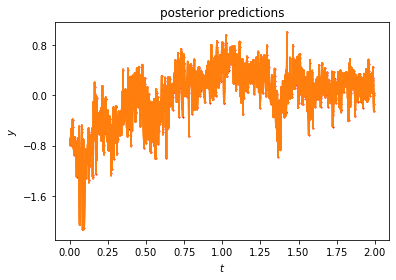

In [16]:
# Plot the data.
plt.scatter(time,flux,c="r",s=1)

# Plot 24 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=24)]:
    gp.set_parameter_vector(s)
    mu = gp.predict(flux, x, return_cov=False)
    plt.plot(x, mu, color=color, alpha=0.3)

plt.ylabel(r"$y$")
plt.xlabel(r"$t$")
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))
plt.title("posterior predictions");